<a href="https://colab.research.google.com/github/Nniikkoollaass/data-science-modul-11-HW/blob/main/DS_HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=1)

    return x

Таким чином, ми додали три шари до класу нейронної мережі: два прихованих і один вихідний. Кожен прихований шар має активаційну функцію сигмоїду, а вихідний шар має активаційну функцію softmax.

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Отримуємо класи з найбільшою ймовірністю
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Розраховуємо точність
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Ця функція спочатку порівнює передбачені класи з фактичними класами, визначеними у векторі y_true. Потім обчислює середнє значення цих порівнянь, щоб отримати загальну точність.

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

  return pred, loss

У цьому коді ми використовуємо градієнтний спуск для оптимізації ваг мережі. Спочатку ми отримуємо прогнозовані значення від нейромережі, обчислюємо втрати, а потім використовуємо метод gradient для обчислення градієнтів відносно цих втрат та ваг мережі. Нарешті, ми застосовуємо ці градієнти до ваг мережі, використовуючи метод apply_gradients.

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    pred, loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        # Обчислимо точність
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print("Шаг: %i, Поточна помилка: %f, Поточна точність: %f" % (step, loss, acc))

Шаг: 100, Поточна помилка: 591.482056, Поточна точність: 0.089844
Шаг: 200, Поточна помилка: 588.017273, Поточна точність: 0.164062
Шаг: 300, Поточна помилка: 586.676270, Поточна точність: 0.210938
Шаг: 400, Поточна помилка: 583.553345, Поточна точність: 0.171875
Шаг: 500, Поточна помилка: 583.844604, Поточна точність: 0.207031
Шаг: 600, Поточна помилка: 580.336670, Поточна точність: 0.207031
Шаг: 700, Поточна помилка: 574.392578, Поточна точність: 0.226562
Шаг: 800, Поточна помилка: 558.904602, Поточна точність: 0.308594
Шаг: 900, Поточна помилка: 558.261230, Поточна точність: 0.269531
Шаг: 1000, Поточна помилка: 548.196411, Поточна точність: 0.277344
Шаг: 1100, Поточна помилка: 540.930054, Поточна точність: 0.378906
Шаг: 1200, Поточна помилка: 521.293457, Поточна точність: 0.378906
Шаг: 1300, Поточна помилка: 522.737793, Поточна точність: 0.332031
Шаг: 1400, Поточна помилка: 510.543793, Поточна точність: 0.355469
Шаг: 1500, Поточна помилка: 493.106781, Поточна точність: 0.304688
Шаг:

У цьому коді ми використовуємо функцію train, щоб оновити ваги мережі на кожному кроці тренування. Після кожних display_step кроків ми обчислюємо точність та помилку та виводимо їх.

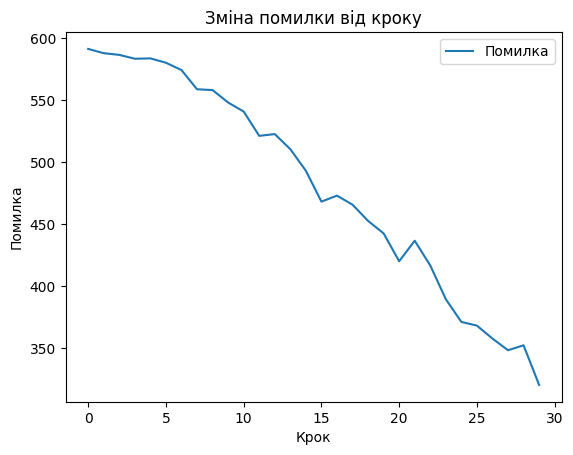

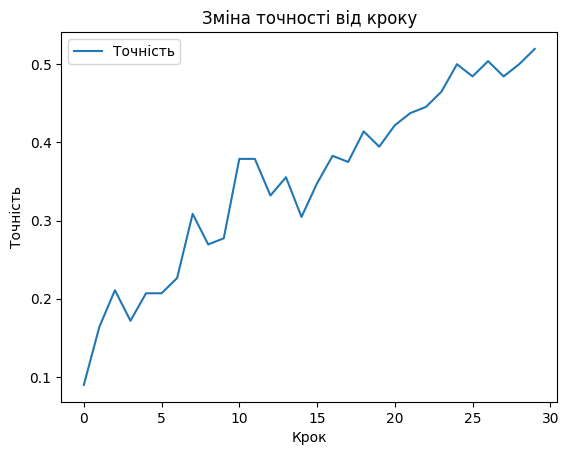

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Помилка')
plt.title('Зміна помилки від кроку')
plt.xlabel('Крок')
plt.ylabel('Помилка')
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Точність')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.legend()
plt.show()

Цей код побудує два графіки: один для зміни втрат від кроку, інший - для зміни точності від кроку.

Точність на тестових даних: 0.523000


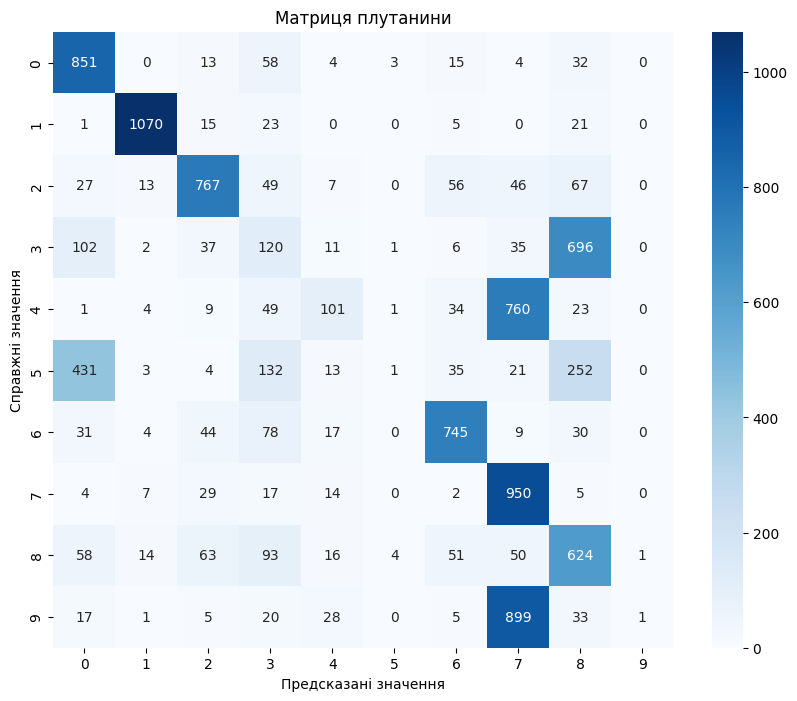

In [9]:
# Обчисліть точність навченої нейромережі
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print("Точність на тестових даних: %f" % test_acc)

# Тестування моделі на тестових даних
predictions = tf.argmax(test_pred, axis=1)
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Предсказані значення')
plt.ylabel('Справжні значення')
plt.title('Матриця плутанини')
plt.show()

Цей код обчислює точність навченої нейромережі на тестових даних та показує матрицю плутанини для оцінки результатів класифікації.

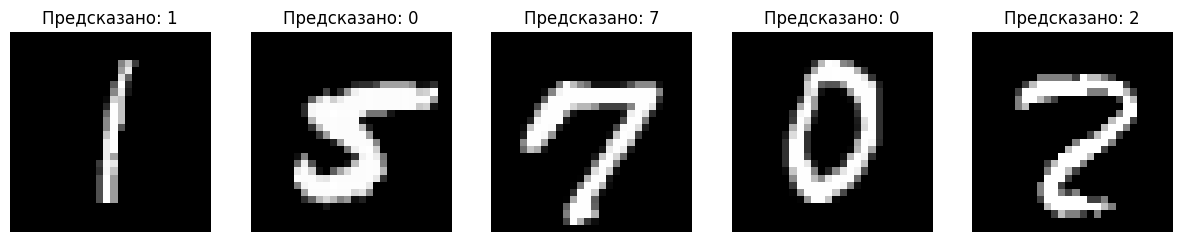

In [10]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Випадковим чином виберемо 5 індексів з тестового набору даних
random_indices = np.random.choice(len(x_test), size=5, replace=False)

# Прогнозуємо класи для вибраних зображень
predicted_classes = tf.argmax(neural_net(x_test[random_indices]), axis=1)

# Виводимо зображення та передбачені класи
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Предсказано: {predicted_classes[i].numpy()}")
    plt.axis('off')
plt.show()

Цей код випадковим чином вибирає 5 зображень з тестового набору даних, передає їх у нейромережу для прогнозування та виводить зображення разом з передбаченими класами поруч. Тепер можна проаналізувати результати, щоб побачити, наскільки часто наша нейромережа помиляється.

Аналіз результатів:

Передана картинка з цифрою 1 - Предсказано 1: Ця передбачена класифікація правильна. Нейромережа правильно визнала цифру 1.

Передана картинка з цифрою 5 - Предсказано 0: У цьому випадку нейромережа помилилась, передбачивши цифру 0 замість 5.

Передана картинка з цифрою 7 - Предсказано 7: Ця передбачена класифікація правильна. Нейромережа правильно визнала цифру 7.

Передана картинка з цифрою 0 - Предсказано 0: Ця передбачена класифікація правильна. Нейромережа правильно визнала цифру 0.

Передана картинка з цифрою 2 - Предсказано 2: Ця передбачена класифікація правильна. Нейромережа правильно визнала цифру 2.

Таким чином, з 5 тестових зображень нейромережа помилилася лише у випадку з передбаченням цифри 5, передбачивши цифру 0 замість 5. Така помилка може бути викликана різними факторами, такими як недостатня складність моделі, недостатнє навчання або неправильне представлення даних. Щоб додатково покращити результати, можна спробувати збільшити складність моделі, збільшити кількість навчальних епох або оптимізувати гіперпараметри моделі.